# Лабораторная работа №15
## Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности
### Вариант 1
*Задание.* Пластина прямоугольной формы с вырезом на одной из сторон жестко закреплена по краям и равномерно нагружена по площади рис 2.8. Прогиб пластины определяется из уравнения Пуассона. Рассчитать прогиб $W(x, y)$ по
данным, приведенным в табл: 2.11 $A, B$ – размеры пластины; $h$ − ее толщина; $R$ – радиус выреза; $P$ – нагрузка; $Е$− модуль упругости; $ν$ – коэффициент Пуассона. Граничное условие $W= 0$.
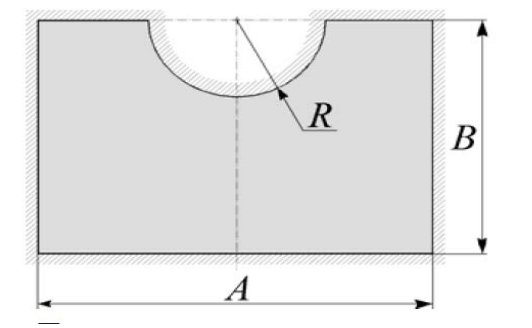

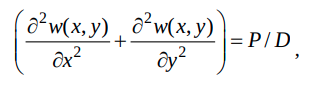
где $D=E*h^3 /[12*(1−ν^2)]$-изгибная жесткость, $E$ – модуль упругости, $h$− толщина пластины, $ν$ – коэффициент Пуассона.

Требуется следующую промоделировать следующий процесс: пластина прямоугольной формы с вырезом на одной из сторон жестко закреплена по краям и равномерно нагружена по площади, прогиб пластины определяется из уравнения Пуассона. При этом рассчитывается прогиб как функция $W(x, y)$ по данным из варианта: $A$, $B$ – размеры пластины; $h$ − ее толщина; $R$ – радиус выреза; $P$ – нагрузка; $Е$ − модуль упругости; $ν$ – коэффициент Пуассона, граничное условие $W$ = 0. Дифференциальное уравнение Пуассона имеет вид:
$$\frac{\delta^2 w(x, y)}{\delta x^2} + \frac{\delta^2 w(x, y)}{\delta y^2} = \frac{P}{D}$$ 
где $D = \frac{Eh^3}{12(1 - v^2)}$ - изгибная жесткость, $E$ – модуль упругости, $h$− толщина пластины, $ν$ – коэффициент Пуассона.

Для решения данного дифференциального уравнения аппроксимируем вторые производные как:
$$ \frac {\partial^2 u}{\partial x^2} = \frac {u(x+h, y) - 2u(x, y) + u(x-h, y)}{h^2} $$$$ \frac {\partial^2 u}{\partial y^2} = \frac {u(x, y+h) - 2u(x, y) + u(x, y-h)}{y^2} $$
Тогда, для каждого внутреннего узла составим разностную схему вида:
$$\frac{W_{i+1, j} - 2W_{i, j} + W_{i-1, j}}{h^2} + \frac{W_{i, j+1} - 2W_{i, j} + W_{i, j+1}}{h^2} = \frac{P}{D}$$
Упростим выражение:
$$W_{i+1, j} + W_{i-1, j} + W_{i, j+1} + W_{i, j+1} - 4W_{i, j} = \frac{Ph^2}{D}$$
Для остальных (граничных и внешних точек) значение $W_{i, j} = 0$. 
Данную разностную схему можно решать как систему линейных уравнений. При этом решение разностной схемы необходимо представить в виде вектора.

Для более эффективной с точки зрения скорости вычисления и памяти реализации алгоритма необходимо использовать разреженные матрицы (так как на одной строке матрицы ненулевыми будут только 5 значений) и решать такую систему можно при помощи встроенных эффективных алгоритмов для разреженных матриц. В данном случае используется метод сопряжённых градиентов.

In [18]:
VARIANT_NUMBER = 10

In [17]:
width = 120
height = 100
radius = 30
thickness = 2
P = 55 * 10**9
E = 70
v = 0.3
function = lambda x, y: P / (E * thickness**3 / (12 * (1 - v**2)))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import typing as tp
import scipy.sparse as spa
import scipy.sparse.linalg as spa_linalg
from mpl_toolkits.mplot3d import Axes3D
from math import *

%matplotlib inline

In [11]:
def solve(width: float, height: float, radius: float, 
          function: tp.Callable[[float, float], float], step: float) -> np.array:
    cols_amount = int(ceil(width / step)) + 1
    rows_amount = int(ceil(height / step)) + 1
    
    total_equations_amount = cols_amount * rows_amount
    data = []
    i_indexes = []
    j_indexes = []
    
    b = np.zeros(total_equations_amount)
    
    def get_mapped_index(i: int, j: int) -> int:
        return cols_amount * i + j
    
    def is_bound_point(i: int, j: int) -> bool:
        x, y = i * step, j * step
        if np.isclose(x, 0) or np.isclose(y, 0):
            return True
        elif x >= height or y >= width:
            return True
        elif x**2 + (y - width / 2)**2 <= radius ** 2:
            return True
        else:
            return False
    
    
    
    for i in range(rows_amount):
        for j in range(cols_amount):
            if not is_bound_point(i, j):
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j - 1))
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j + 1))
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i + 1, j))
    
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i - 1, j))
    
    
                data.append(-4)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j))
    
                b[get_mapped_index(i, j)] = function(i * step, j * step) * step**2
            else:
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j))
    A = spa.coo_matrix((data, (i_indexes, j_indexes)))
    solution = spa_linalg.cg(A, b)[0]
    return solution.reshape((rows_amount, cols_amount))  

def plot_solution(solution: np.array, width: float, height: float, step: float) -> None:
    y = np.arange(0, height + step, step)
    x = np.arange(0, width + step, step)
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, solution, cmap='summer')

Вычислим решение разностной схемы с шагом  $h=1$

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.49806689e+09 -4.45797755e+09 ... -4.45797755e+09
  -2.49806689e+09  0.00000000e+00]
 [ 0.00000000e+00 -4.46177213e+09 -8.17153024e+09 ... -8.17153024e+09
  -4.46177213e+09  0.00000000e+00]
 ...
 [ 0.00000000e+00 -5.19681399e+09 -9.64561202e+09 ... -9.64561202e+09
  -5.19681399e+09  0.00000000e+00]
 [ 0.00000000e+00 -2.86659082e+09 -5.19703369e+09 ... -5.19703369e+09
  -2.86659082e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


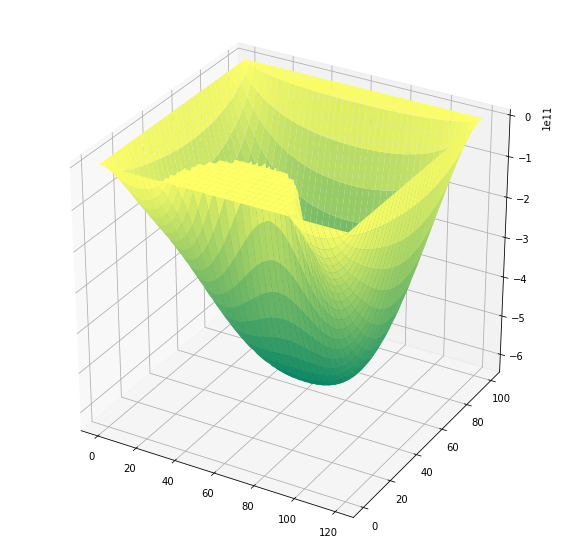

In [20]:
solution = solve(width, height, radius, function, 1)
print(solution)
plot_solution(solution, width, height, 1)

Вычислим решение разностной схемы с шагом 2

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.12525211e+09 -1.40760099e+10 ... -1.40760099e+10
  -8.12525211e+09  0.00000000e+00]
 [ 0.00000000e+00 -1.41349872e+10 -2.52192107e+10 ... -2.52192107e+10
  -1.41349872e+10  0.00000000e+00]
 ...
 [ 0.00000000e+00 -1.70163217e+10 -3.10432439e+10 ... -3.10432439e+10
  -1.70163217e+10  0.00000000e+00]
 [ 0.00000000e+00 -9.58156318e+09 -1.70198700e+10 ... -1.70198700e+10
  -9.58156318e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


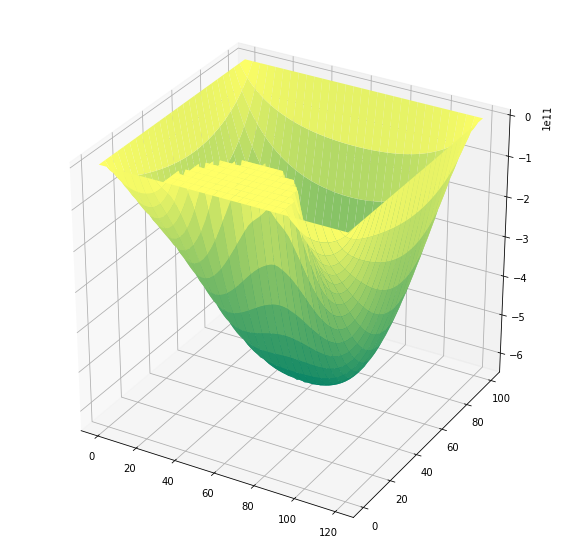

In [21]:
solution = solve(width, height, radius, function, 2)
print(solution)
plot_solution(solution, width, height, 2)

Вычислим решение разностной схемы с шагом 10

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.01736905e+11 -1.37692934e+11 -1.10654902e+11
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.10654902e+11 -1.37692934e+11 -1.01736905e+11
   0.00000000e+00]
 [ 0.00000000e+00 -1.62004771e+11 -2.31129584e+11 -1.97676355e+11
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.97676355e+11 -2.31129584e+11 -1.62004771e+11
   0.00000000e+00]
 [ 0.00000000e+00 -2.07902219e+11 -3.19893650e+11 -3.41671506e+11
  -2.80954127e+11 -2.07350008e+11  0.00000000e+00 -2.07350008e+11
  -2.80954127e+11 -3.41671506e+11 -3.19893650e+11 -2.07902219e+11
   0.00000000e+00]
 [ 0.00000000e+00 -2.42460733e+11 -3.91620994e+11 -4.60912155e+11
  -4.67545330e+11 -4.41196131e+11 -3.93155071e+11 -4.41196131e+11


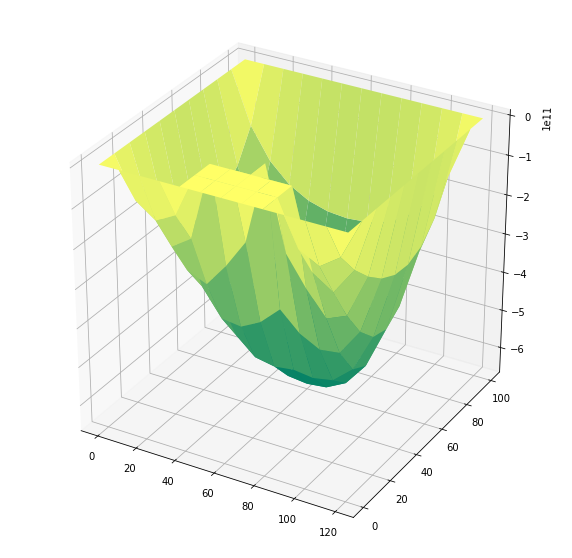

In [22]:
solution = solve(width, height, radius, function, 10)
print(solution)
plot_solution(solution, width, height, 10)

Как видно из данных графиков, полученный результат соответствует практическим результатам. При этом, при увеличении шага сетки, ухудшается качество аппроксимации функции.